<a href="https://colab.research.google.com/github/garg-aayush/Pytorch_Examples/blob/master/02_CNN_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Example**: 
####Image classification using ResNets for [CIFAR-10 data](https://www.cs.toronto.edu/~kriz/cifar.html)

##### Import the required modules 

In [2]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch

# for plotting 
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline

# To visualize the network
from torchsummary import summary
!pip install torchviz #git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=254e0f9638442918dc90bc73e3ecbb9f93274c0207c5f32ecf2b3885958d0b79
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


##### Get the device configuration


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Check and mount the DATA and MODEL paths

**NOTE**: make sure to mount the google drive



In [0]:
DATAPATH = '/content/drive/My Drive/DATASETS/'      # folder to save the CIFAR-10 dataset
MODELPATH = '/content/drive/My Drive/MODELS/'       # folder to save the TRAINED MODEL

#### Set the hyperparameters

In [0]:
num_epochs = 80                  # number of times go through the data
num_classes = 10                 # number of output classes (CIFAR-10: 10 image classes)
batch_size = 100                  # number of input/output pairs to use for updating the weights (mini-batch approach)
learning_rate = 0.001            # alpha :  w_new = w_old - alpha * dw

#### Make a list of image transforms to apply to data

In [0]:
trans_train = transforms.Compose([transforms.Pad(4), 
                            transforms.RandomHorizontalFlip(), 
                            transforms.RandomCrop(32), 
                            transforms.ToTensor()])

trans_test = transforms.Compose([transforms.ToTensor()])



#### Load the CIFAR-10 datasets and Q.C. the data

In [7]:
# Returns a tuple containing the input image and label
train_dataset = torchvision.datasets.CIFAR10(DATAPATH, train=True, transform=trans_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(DATAPATH, train=False, transform=trans_test, download=False)

Extracting /content/drive/My Drive/DATASETS/cifar-10-python.tar.gz to /content/drive/My Drive/DATASETS/


Training examples : 50000
Size : torch.Size([3, 32, 32])

Test examples : 10000
Size : torch.Size([3, 32, 32])



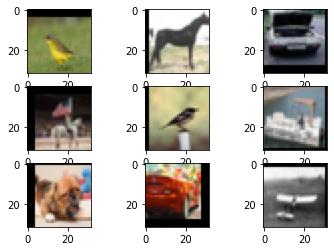

In [8]:
# Check the dimensions of datasets and plot them 
print('Training examples : {}'.format(len(train_dataset)))
print('Size : {}'.format(format(train_dataset[0][0].size())))
print()
print('Test examples : {}'.format(len(test_dataset)))
print('Size : {}'.format(format(test_dataset[0][0].size())))
print()

# plot some training example
rand_vec = sample(range(0, len(train_dataset)), 9)

for i in range(len(rand_vec)):
    # define subplot
    plt.subplot(330 + 1 + i)
    # remember to permute size (channels, height, width) --> (height, width, channels) for plotting
    plt_case = train_dataset[rand_vec[i]][0].permute([1, 2, 0])
    # plot raw pixel data
    plt.imshow(plt_case)

# show the figure
plt.show()

In [0]:
# Create the Dataloaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#### Make the network


In [0]:
# Function to make a convolutional layer with 3X3 filter length
# As we only use 3X3 filters for all CNN layers

# see https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3X3(in_channels, out_channels, stride=1):
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

# Class for a residual block
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(ResidualBlock, self).__init__()

    # Convolutions
    self.conv1 = conv3X3(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3X3(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
  
  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    
    if self.downsample :
      residual = self.downsample(x)
    out += residual
    
    out = self.relu(out)
    
    return out  



#### Q.C the residual block

In [0]:
# 1. when number of input and output channels are same
qc_toggle = 0
if qc_toggle == 1:
  
  # print te model summary (Not exactly great)
  temp_block = ResidualBlock(16,16)
  print(temp_block)
  print()

  # Slightly better summary, however not good to visualize skip connections
  summary(temp_block, input_size=(16,32,32))
  print()

  # Use make_dot from torcviz to visualize the graph
  temp_x = torch.randn(1, 16, 32, 32).requires_grad_(True)
  temp_y = temp_block(temp_x)
  make_dot(temp_y, params=dict(list(temp_block.named_parameters()) + [('x', temp_x)]))

In [0]:
# 2. when number of input and output channels are different 
qc_toggle = 0
if qc_toggle == 1:

  # print te model summary (Not exactly great)
  temp_block = ResidualBlock(16,32, stride=2, downsample=nn.Sequential(conv3X3(16,32,stride=2), nn.BatchNorm2d(32)))
  print(temp_block)
  print()

  # Slightly better summary, however not good to visualize skip connections
  summary(temp_block, input_size=(16,32,32))
  print()

  # Use make_dot from torcviz to visualize the graph
  temp_x = torch.randn(1, 16, 32, 32).requires_grad_(True)
  temp_y = temp_block(temp_x)
  make_dot(temp_y, params=dict(list(temp_block.named_parameters()) + [('x', temp_x)]))

#### Instantiate te ResNet

In [0]:

# Class for the ResNet
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 10):
    super(ResNet, self).__init__()

    self.in_channels = 16
    self.conv = conv3X3(in_channels=3, out_channels=16)
    self.bn = nn.BatchNorm2d(num_features=16)
    self.relu = nn.ReLU(inplace=True)

    self.layer1 = self.make_layer(block, 16, layers[0])
    self.layer2 = self.make_layer(block, 32, layers[1], 2)
    self.layer3 = self.make_layer(block, 64, layers[2], 2)

    self.avgpool = nn.AvgPool2d(8)
    self.fc = nn.Linear(64, num_classes)
    
  def make_layer(self, block, out_channels, blocks, stride=1):
    # Create the downsample layer if conditions are met
    downsample = None
    if (stride != 1) or (self.in_channels != out_channels):
      downsample = nn.Sequential(conv3X3(self.in_channels, out_channels, stride=stride),
                                 nn.BatchNorm2d(out_channels))
    
    # Make all the layers 
    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels
    for i in range(1, blocks):
      layers.append(block(out_channels, out_channels))

    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)

    return out

In [0]:
# Create the network instance
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

#### Q.C. the ResNet


In [0]:
# ONLY RUN this cell to Q.C. th NETWORK
qc_toggle = 0
if qc_toggle == 1:
  # print te model summary (Not exactly great)
  print(model)
  print()

  # Slightly better summary, however not good to visualize skip connections
  summary(model, input_size=(3,32,32))
  print()

  # Use make_dot from torcviz to visualize the graph
  temp_x = torch.randn(1, 3, 32, 32).requires_grad_(True)
  temp_y = model(temp_x)
  make_dot(temp_y, params=dict(list(model.named_parameters()) + [('x', temp_x)]))

#### Train the network

In [16]:
# set the loss-criterion
criterion = nn.CrossEntropyLoss()     # Combines the softmax fn and the -inve log-likelihood fn

# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def update_lr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

total_step = len(train_loader)
curr_lr = learning_rate

loss_list = []                      # list to save the losses
acc_list = []                       # list to save and check the accuracy at each step


for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    
    # transfer to GPU if device CUDA
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())         # .item() loss is a scaler tensor quantity

    # Backward pass to optimize and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Check the accuracy
    total = labels.size(0)                        # as shape (num. of examples, ....)
    _, predicted = torch.max(outputs.data,1)      # as .max returns value, index. Here, index corresponds number where value is 1
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    # print the information at every 100th step
    if (i+1) % 100 == 0:
      print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch +1, num_epochs, i+1, total_step, loss.item(), (correct / total)*100))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


Epoch [1/80], Step[100/500], Loss: 1.6863, Accuracy: 36.00%
Epoch [1/80], Step[200/500], Loss: 1.3607, Accuracy: 51.00%
Epoch [1/80], Step[300/500], Loss: 1.2876, Accuracy: 50.00%
Epoch [1/80], Step[400/500], Loss: 1.2318, Accuracy: 49.00%
Epoch [1/80], Step[500/500], Loss: 1.1787, Accuracy: 63.00%
Epoch [2/80], Step[100/500], Loss: 0.9413, Accuracy: 63.00%
Epoch [2/80], Step[200/500], Loss: 0.8974, Accuracy: 70.00%
Epoch [2/80], Step[300/500], Loss: 0.9179, Accuracy: 69.00%
Epoch [2/80], Step[400/500], Loss: 0.9499, Accuracy: 70.00%
Epoch [2/80], Step[500/500], Loss: 1.1793, Accuracy: 60.00%
Epoch [3/80], Step[100/500], Loss: 0.7334, Accuracy: 77.00%
Epoch [3/80], Step[200/500], Loss: 0.9474, Accuracy: 66.00%
Epoch [3/80], Step[300/500], Loss: 0.7234, Accuracy: 72.00%
Epoch [3/80], Step[400/500], Loss: 0.6586, Accuracy: 75.00%
Epoch [3/80], Step[500/500], Loss: 0.7162, Accuracy: 71.00%
Epoch [4/80], Step[100/500], Loss: 0.7490, Accuracy: 76.00%
Epoch [4/80], Step[200/500], Loss: 0.755

In [17]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 85.36 %
